In [1]:
# Importing Libraries and Warnings
# --------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from datetime import date

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Imports for Linear Regression
# -----------------------------
# sklearn:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


# statsmodels:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Reading the Dataset
# ===================

df = pd.read_csv('day.csv')

df.head(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [4]:
df.drop(['instant','dteday'],axis = 1, inplace = True)

In [5]:
# Before Proceeding, we convert all non-binary variables that are categorical 
# from 'integer' type to 'string'
#
# These columns include - 
#      'season', 'yr', 'mnth', 'holiday',
#      'weekday', 'workingday', 'weathersit'
# ------------------------------------------------------------------------------------------------
def conv_season(x):
    return x.map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})
df[['season']] = df[['season']].apply(conv_season)

def conv_year(x):
    return x.map({0: '2018', 1:'2019'})
df[['yr']] = df[['yr']].apply(conv_year)

def conv_months(x):
    return x.map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 
                  5:'May', 6:'June', 7:'July', 8:'Aug', 
                  9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'})
df[['mnth']] = df[['mnth']].apply(conv_months)

def conv_holiday(x):
    return x.map({0:'Not Holiday', 1:'Holiday'})
df[['holiday']] = df[['holiday']].apply(conv_holiday)

def conv_working_day(x):
    return x.map({0:'Weekend', 1:'Working Day'})
df[['workingday']] = df[['workingday']].apply(conv_working_day)

def conv_weekday(x):
    return x.map({1:'Mon', 2:'Tue', 3:'Wed', 4:'Thur', 
                  5:'Fri', 6:'Sat', 0:'Sun'})
df[['weekday']] = df[['weekday']].apply(conv_weekday)



# Weathersit
# ----------
# 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

def conv_weathersit(x):
    return x.map({1:'Clear/Partly-Cloudy', 
                  2:'Mist/Cloudy', 
                  3:'Light-Rain-Snow/Thunderstorm', 
                  4:'Heavy/Rain/Ice-Pallets/Snow-Fog/Thunderstorm'})
df[['weathersit']] = df[['weathersit']].apply(conv_weathersit)

In [6]:
df_numerical = df.select_dtypes(include=['int64', 'float64'])
df_categorical = df.select_dtypes(exclude=['int64', 'float64'])

In [7]:
# Encoding
# Conversion for Year 'yr'
def bin_year(x):
    if x == '2018':
        return 0
    else:
        return 1

df['yr'] = df['yr'].apply(bin_year)
# ----------------------------------------------------------------
# Conversion for Holiday or Not Holiday 'holiday'
def bin_holiday(x):
    if x=='Holiday':
        return 1
    else:
        return 0
    
df['holiday'] = df['holiday'].apply(bin_holiday)
# ----------------------------------------------------------------
# Conversion for working day or not working day 'workingday'
def bin_workingday(x):
    if x == 'Weekend':
        return 0
    else:
        return 1

df['workingday'] = df['workingday'].apply(bin_workingday)
# ----------------------------------------------------------------
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,Spring,0,Jan,0,Mon,1,Mist/Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,Spring,0,Jan,0,Tue,1,Mist/Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
2,Spring,0,Jan,0,Wed,1,Clear/Partly-Cloudy,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,Spring,0,Jan,0,Thur,1,Clear/Partly-Cloudy,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,Spring,0,Jan,0,Fri,1,Clear/Partly-Cloudy,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [8]:
df_non_binary_categorical = df[['season','mnth','weekday','weathersit']]

# One Hot Encoding (OHE) by using the get_dummies()
# We will also remove the redundant column using --> drop_first argument in get_dummies()
# Reference - https://stackoverflow.com/questions/50176096/removing-redundant-columns-when-using-get-dummies
df_dummies = pd.get_dummies(df_non_binary_categorical, drop_first = True)
df_dummies.head(2)

,season_Spring,season_Summer,season_Winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_July,mnth_June,mnth_Mar,...,mnth_Oct,mnth_Sept,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thur,weekday_Tue,weekday_Wed,weathersit_Light-Rain-Snow/Thunderstorm,weathersit_Mist/Cloudy
0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [1]:
# df_dummies.info()

In [10]:
# Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'
# -----------------------------------------------------------------------
df = df.drop(df_non_binary_categorical, axis=1)
df = pd.concat([df, df_dummies], axis=1)
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,mnth_Oct,mnth_Sept,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thur,weekday_Tue,weekday_Wed,weathersit_Light-Rain-Snow/Thunderstorm,weathersit_Mist/Cloudy
0,0,0,1,14.110847,18.18125,80.5833,10.749882,331,654,985,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,14.902598,17.68695,69.6087,16.652113,131,670,801,...,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# df.info()

In [12]:
# TEST-TRAIN SPLIT
# ----------------

np.random.seed(0)   # We specify this so that the train and 
                    # test data set always have the same rows, respectively

df_train, df_test = train_test_split(df, train_size = 0.75, test_size = 0.25, random_state = 100)

print("Shape of TRAIN:",df_train.shape)
print("Shape of TEST: ",df_test.shape)

Shape of TRAIN: (547, 32)
Shape of TEST:  (183, 32)


In [13]:
# RE-SCALING
# ----------
scaler = MinMaxScaler()
# Since we have already scaled the categorical variables
# i.e. all their values are between 0 and 1.
# So, we will only scale the numerical variables here
# 
num_vars = ['temp', 'atemp', 'hum', 'windspeed','casual', 'registered', 'cnt']

# Applying fit-transform on the data.
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,mnth_Oct,mnth_Sept,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thur,weekday_Tue,weekday_Wed,weathersit_Light-Rain-Snow/Thunderstorm,weathersit_Mist/Cloudy
311,0,0,1,0.435124,0.437339,0.743667,0.057471,0.113990,0.549957,0.481247,...,0,0,0,0,0,1,0,0,0,0
523,1,0,0,0.735215,0.680985,0.482181,0.286093,0.452911,0.899220,0.887483,...,0,0,0,1,0,0,0,0,0,0
381,1,0,1,0.391151,0.374375,0.737917,0.659615,0.038098,0.402541,0.335136,...,0,0,0,0,0,1,0,0,0,1
413,1,0,1,0.358285,0.362754,0.550880,0.319514,0.436757,0.413370,0.494248,...,0,0,1,0,0,0,0,0,0,0
253,0,0,1,0.740406,0.695906,0.735509,0.156398,0.497105,0.489893,0.578003,...,0,1,0,0,0,0,1,0,0,0


In [3]:
# df_train.info()

In [15]:
# ASSIGNING VARIABLES
# -------------------
y_train = df_train.pop('cnt')
X_train = df_train

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
# Running RFE with O/P value as 15
# --------------------------------
rfe = RFE(lr, 15)             
rfe = rfe.fit(X_train, y_train)

In [19]:
# We list all the variables/columns of the dataset with their rfe ranking
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', False, 13),
 ('windspeed', False, 12),
 ('casual', True, 1),
 ('registered', True, 1),
 ('season_Spring', True, 1),
 ('season_Summer', False, 11),
 ('season_Winter', False, 17),
 ('mnth_Aug', False, 14),
 ('mnth_Dec', True, 1),
 ('mnth_Feb', True, 1),
 ('mnth_Jan', True, 1),
 ('mnth_July', True, 1),
 ('mnth_June', True, 1),
 ('mnth_Mar', False, 2),
 ('mnth_May', False, 6),
 ('mnth_Nov', True, 1),
 ('mnth_Oct', False, 15),
 ('mnth_Sept', False, 16),
 ('weekday_Mon', True, 1),
 ('weekday_Sat', False, 5),
 ('weekday_Sun', False, 3),
 ('weekday_Thur', False, 4),
 ('weekday_Tue', False, 9),
 ('weekday_Wed', False, 8),
 ('weathersit_Light-Rain-Snow/Thunderstorm', False, 7),
 ('weathersit_Mist/Cloudy', False, 10)]

In [20]:
# The indepdendent variables to be selected are - 
# ---------------------------------------------
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'casual', 'registered',
       'season_Spring', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_July',
       'mnth_June', 'mnth_Nov', 'weekday_Mon'],
      dtype='object')

In [21]:
# The independent variables that are to be rejected are - 
# -----------------------------------------------------
X_train.columns[~rfe.support_]

Index(['hum', 'windspeed', 'season_Summer', 'season_Winter', 'mnth_Aug',
       'mnth_Mar', 'mnth_May', 'mnth_Oct', 'mnth_Sept', 'weekday_Sat',
       'weekday_Sun', 'weekday_Thur', 'weekday_Tue', 'weekday_Wed',
       'weathersit_Light-Rain-Snow/Thunderstorm', 'weathersit_Mist/Cloudy'],
      dtype='object')

In [22]:
# Creating X_test dataframe with RFE selected variables
X_train_RFE = X_train[col]

In [23]:
X_train_RFE.head()

,yr,holiday,workingday,temp,atemp,casual,registered,season_Spring,mnth_Dec,mnth_Feb,mnth_Jan,mnth_July,mnth_June,mnth_Nov,weekday_Mon
311,0,0,1,0.435124,0.437339,0.113990,0.549957,0,0,0,0,0,0,1,0
523,1,0,0,0.735215,0.680985,0.452911,0.899220,0,0,0,0,0,1,0,0
381,1,0,1,0.391151,0.374375,0.038098,0.402541,1,0,0,1,0,0,0,0
413,1,0,1,0.358285,0.362754,0.436757,0.413370,1,0,1,0,0,0,0,1
253,0,0,1,0.740406,0.695906,0.497105,0.489893,0,0,0,0,0,0,0,0


In [24]:
# Running Model 1
# ===============
# Adding a constant variable 
X_train_sm = sm.add_constant(X_train_RFE)

# Running the linear model
lr_mod_1 = sm.OLS(y_train,X_train_sm)

# Fitting the Model
lr_mod_1 = lr_mod_1.fit()

#Let's see the summary of our linear model
lr_mod_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.623e+29
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:58:25   Log-Likelihood:                 17591.
No. Observations:                 547   AIC:                        -3.515e+04
Df Residuals:                     531   BIC:                        -3.508e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.967e-16   6.67e-16      0.894      0.372   -7.14e-16    1.91e-15
yr             5.065e-16   3.43e-16      1.478      0.140   -1.67e-16    1.18e-15
holiday       -1.318e-16   7.44e-16     -0.177      0.859   -1.59e-15    1.33e-15
workingday     8.327e-16   2.81e-16      2.964      0.003    2.81e-16    1.38e-15
temp          -5.551e-17   3.68e-15     -0.015      0.988   -7.28e-15    7.17e-15
atemp          1.665e-15   3.87e-15      0.431      0.667   -5.93e-15    9.26e-15
casual            0.3775   8.11e-16   4.65e+14      0.000       0.377       0.377
registered        0.7968   9.62e-16   8.28e+14      0.000       0.797       0.797
season_Spring  3.539e-16    4.6e-16      0.770      0.442   -5.49e-16    1.26e-15
mnth_Dec       5.551e-17   4.83e-16      0.115      0.909   -8.94e-16    1.01e-15
mnth_Feb       8.327e-17   5.97e-16      0.140      0.889   -1.09e-15    1.26e-15
mnth_Jan       2.637e-16   5.92e-16      0.445      0.656      -9e-16    1.43e-15
mnth_July     -4.163e-17   5.11e-16     -0.081      0.935   -1.05e-15    9.62e-16
mnth_June      2.082e-16   4.58e-16      0.454      0.650   -6.92e-16    1.11e-15
mnth_Nov      -6.939e-17   4.85e-16     -0.143      0.886   -1.02e-15    8.83e-16
weekday_Mon    2.984e-16   3.95e-16      0.756      0.450   -4.77e-16    1.07e-15
==============================================================================
Omnibus:                       13.696   Durbin-Watson:                   0.102
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               11.809
Skew:                           0.290   Prob(JB):                      0.00273
Kurtosis:                       2.575   Cond. No.                         79.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# Calculate the VIFs (Variance Inflation Factor):
# ----------------------------------------------
vif = pd.DataFrame()
vif['Features'] = X_train_RFE.columns
vif['VIF'] = [variance_inflation_factor(X_train_RFE.values, i) for i in range(X_train_RFE.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,atemp,355.71
3,temp,349.95
6,registered,21.15
5,casual,5.35
0,yr,4.48
2,workingday,4.07
7,season_Spring,3.33
10,mnth_Jan,2.17
9,mnth_Feb,1.94
14,weekday_Mon,1.83


In [26]:
# Obeservations for Model 1
# -------------------------
# We find R = 1.0, which means that the Model 1 overfitted.
# One of the reasons for this might be Multi-collinearity.
# The variable 'temp' has the highest P-value (0.988)
# The variable 'atemp' has the highest VIF value(355.71),
# So we can drop the column 'atemp' columns.

In [27]:
# Dropping the 'atemp' columns
X_train_RFE.drop('atemp', axis=1, inplace=True)

# Running Model 2 ('temp' removed)
# ===============
# Adding a constant variable 
X_train_sm = sm.add_constant(X_train_RFE)

# Running the linear model
lr_mod_2 = sm.OLS(y_train,X_train_sm)

# Fitting the Model
lr_mod_2 = lr_mod_2.fit()

#Let's see the summary of our linear model
lr_mod_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.649e+29
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:58:26   Log-Likelihood:                 17782.
No. Observations:                 547   AIC:                        -3.553e+04
Df Residuals:                     532   BIC:                        -3.547e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          9.021e-16    4.7e-16      1.918      0.056   -2.17e-17    1.83e-15
yr             5.243e-16   2.41e-16      2.176      0.030     5.1e-17    9.98e-16
holiday       -9.021e-17   5.25e-16     -0.172      0.864   -1.12e-15     9.4e-16
workingday      7.91e-16   1.98e-16      4.005      0.000    4.03e-16    1.18e-15
temp          -2.498e-16   7.13e-16     -0.350      0.726   -1.65e-15    1.15e-15
casual            0.3775   5.71e-16   6.61e+14      0.000       0.377       0.377
registered        0.7968   6.76e-16   1.18e+15      0.000       0.797       0.797
season_Spring  3.192e-16   3.24e-16      0.984      0.325   -3.18e-16    9.56e-16
mnth_Dec       -2.22e-16   3.41e-16     -0.652      0.515   -8.91e-16    4.47e-16
mnth_Feb      -2.082e-16   4.21e-16     -0.495      0.621   -1.03e-15    6.19e-16
mnth_Jan      -2.151e-16   4.18e-16     -0.515      0.607   -1.04e-15    6.05e-16
mnth_July      2.776e-17    3.6e-16      0.077      0.939    -6.8e-16    7.36e-16
mnth_June      8.674e-17   3.23e-16      0.269      0.788   -5.47e-16    7.21e-16
mnth_Nov        -3.4e-16   3.42e-16     -0.995      0.320   -1.01e-15    3.31e-16
weekday_Mon    1.318e-16   2.78e-16      0.474      0.636   -4.15e-16    6.79e-16
==============================================================================
Omnibus:                       25.251   Durbin-Watson:                   0.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.381
Skew:                           0.408   Prob(JB):                     2.28e-05
Kurtosis:                       2.479   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# Calculate the VIFs (Variance Inflation Factor):
# ----------------------------------------------
vif = pd.DataFrame()
vif['Features'] = X_train_RFE.columns
vif['VIF'] = [variance_inflation_factor(X_train_RFE.values, i) for i in range(X_train_RFE.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,registered,20.93
3,temp,16.68
4,casual,5.33
0,yr,4.45
2,workingday,4.03
6,season_Spring,3.33
9,mnth_Jan,2.17
8,mnth_Feb,1.94
13,weekday_Mon,1.83
10,mnth_July,1.37


In [29]:
# Obeservations for Model 2
# -------------------------
# We find R = 1.0, which means that the Model 2 also overfitted.
# One of the reasons for this might be Multi-collinearity.
# The variable 'mnth_July' has the highest P-value (0.939)
# The variable 'registered' has the highest VIF value(20.93),
# So we can drop the column 'registered' columns.

In [30]:
# Droppin the 'registered' Column
X_train_RFE.drop('registered', inplace=True, axis=1)

# Running Model 3 ('weekday_Mon' removed)
# ===============
# Adding a constant variable 
X_train_sm = sm.add_constant(X_train_RFE)

# Running the linear model
lr_mod_3 = sm.OLS(y_train,X_train_sm)

# Fitting the Model
lr_mod_3 = lr_mod_3.fit()

#Let's see the summary of our linear model
lr_mod_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     192.6
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          1.21e-191
Time:                        21:58:27   Log-Likelihood:                 516.11
No. Observations:                 547   AIC:                            -1004.
Df Residuals:                     533   BIC:                            -944.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1752      0.023      7.694      0.000       0.130       0.220
yr                0.2039      0.009     23.820      0.000       0.187       0.221
holiday          -0.1109      0.026     -4.208      0.000      -0.163      -0.059
workingday        0.0225      0.010      2.241      0.025       0.003       0.042
temp              0.2911      0.034      8.520      0.000       0.224       0.358
casual            0.4201      0.029     14.438      0.000       0.363       0.477
season_Spring    -0.1053      0.016     -6.617      0.000      -0.137      -0.074
mnth_Dec          0.0297      0.017      1.716      0.087      -0.004       0.064
mnth_Feb          0.0052      0.021      0.240      0.810      -0.037       0.047
mnth_Jan         -0.0080      0.021     -0.373      0.709      -0.050       0.034
mnth_July        -0.0518      0.018     -2.840      0.005      -0.088      -0.016
mnth_June        -0.0007      0.016     -0.040      0.968      -0.033       0.032
mnth_Nov          0.0284      0.017      1.635      0.103      -0.006       0.063
weekday_Mon      -0.1102      0.013     -8.237      0.000      -0.136      -0.084
==============================================================================
Omnibus:                       95.526   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.672
Skew:                          -0.950   Prob(JB):                     9.78e-45
Kurtosis:                       5.298   Cond. No.                         16.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# Calculate the VIFs (Variance Inflation Factor):
# ----------------------------------------------
vif = pd.DataFrame()
vif['Features'] = X_train_RFE.columns
vif['VIF'] = [variance_inflation_factor(X_train_RFE.values, i) for i in range(X_train_RFE.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,temp,7.94
4,casual,5.27
2,workingday,3.86
5,season_Spring,3.25
0,yr,2.23
8,mnth_Jan,2.15
7,mnth_Feb,1.92
12,weekday_Mon,1.63
9,mnth_July,1.31
10,mnth_June,1.24


In [32]:
# Obeservations for Model 3
# -------------------------
# We find R = 0.824, which is a very high value.
# 
# We also find the P-value of mnth_June as (0.986) to be the highest.
# The VIF score for temp is (7.94), which is still high
# We drop the 'temp' column then.

In [33]:
# Dropping the 'temp' column
X_train_RFE.drop('temp', inplace=True, axis=1)

# Running Model 4 ('temp' removed)
# ===============
# Adding a constant variable 
X_train_sm = sm.add_constant(X_train_RFE)

# Running the linear model
lr_mod_4 = sm.OLS(y_train,X_train_sm)

# Fitting the Model
lr_mod_4 = lr_mod_4.fit()

#Let's see the summary of our linear model
lr_mod_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     178.6
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          4.52e-178
Time:                        21:58:28   Log-Likelihood:                 481.18
No. Observations:                 547   AIC:                            -936.4
Df Residuals:                     534   BIC:                            -880.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3333      0.014     23.738      0.000       0.306       0.361
yr                0.2054      0.009     22.543      0.000       0.188       0.223
holiday          -0.1038      0.028     -3.702      0.000      -0.159      -0.049
workingday        0.0263      0.011      2.467      0.014       0.005       0.047
casual            0.4885      0.030     16.399      0.000       0.430       0.547
season_Spring    -0.1482      0.016     -9.225      0.000      -0.180      -0.117
mnth_Dec         -0.0245      0.017     -1.427      0.154      -0.058       0.009
mnth_Feb         -0.0307      0.022     -1.368      0.172      -0.075       0.013
mnth_Jan         -0.0647      0.022     -3.000      0.003      -0.107      -0.022
mnth_July         0.0154      0.018      0.881      0.378      -0.019       0.050
mnth_June         0.0383      0.017      2.272      0.023       0.005       0.071
mnth_Nov         -0.0280      0.017     -1.634      0.103      -0.062       0.006
weekday_Mon      -0.1302      0.014     -9.287      0.000      -0.158      -0.103
==============================================================================
Omnibus:                       94.780   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.869
Skew:                          -0.954   Prob(JB):                     2.93e-43
Kurtosis:                       5.226   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# Calculate the VIFs (Variance Inflation Factor):
# ----------------------------------------------
vif = pd.DataFrame()
vif['Features'] = X_train_RFE.columns
vif['VIF'] = [variance_inflation_factor(X_train_RFE.values, i) for i in range(X_train_RFE.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,season_Spring,3.25
3,casual,2.90
2,workingday,2.56
0,yr,2.21
7,mnth_Jan,2.14
6,mnth_Feb,1.92
11,weekday_Mon,1.44
5,mnth_Dec,1.22
9,mnth_June,1.17
10,mnth_Nov,1.16


In [35]:

X_train_RFE.drop('mnth_July', inplace=True, axis=1)

# Running Model 5 ('mnth_July' removed)
# ===============
# Adding a constant variable 
X_train_sm = sm.add_constant(X_train_RFE)

# Running the linear model
lr_mod_5 = sm.OLS(y_train,X_train_sm)

# Fitting the Model
lr_mod_5 = lr_mod_5.fit()

#Let's see the summary of our linear model
lr_mod_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     194.9
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          4.65e-179
Time:                        21:58:43   Log-Likelihood:                 480.79
No. Observations:                 547   AIC:                            -937.6
Df Residuals:                     535   BIC:                            -885.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3350      0.014     24.069      0.000       0.308       0.362
yr                0.2054      0.009     22.541      0.000       0.187       0.223
holiday          -0.1044      0.028     -3.727      0.000      -0.159      -0.049
workingday        0.0262      0.011      2.453      0.014       0.005       0.047
casual            0.4902      0.030     16.495      0.000       0.432       0.549
season_Spring    -0.1496      0.016     -9.357      0.000      -0.181      -0.118
mnth_Dec         -0.0257      0.017     -1.501      0.134      -0.059       0.008
mnth_Feb         -0.0309      0.022     -1.378      0.169      -0.075       0.013
mnth_Jan         -0.0649      0.022     -3.009      0.003      -0.107      -0.023
mnth_June         0.0362      0.017      2.168      0.031       0.003       0.069
mnth_Nov         -0.0297      0.017     -1.747      0.081      -0.063       0.004
weekday_Mon      -0.1302      0.014     -9.285      0.000      -0.158      -0.103
==============================================================================
Omnibus:                       96.208   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.097
Skew:                          -0.967   Prob(JB):                     5.84e-44
Kurtosis:                       5.235   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
X_train_RFE.drop('mnth_Feb', inplace=True, axis=1)

# Running Model 6 ('mnth_Feb' removed)
# ===============
# Adding a constant variable 
X_train_sm = sm.add_constant(X_train_RFE)

# Running the linear model
lr_mod_6 = sm.OLS(y_train,X_train_sm)

# Fitting the Model
lr_mod_6 = lr_mod_6.fit()

#Let's see the summary of our linear model
lr_mod_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     213.8
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          7.97e-180
Time:                        21:59:31   Log-Likelihood:                 479.82
No. Observations:                 547   AIC:                            -937.6
Df Residuals:                     536   BIC:                            -890.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3328      0.014     24.051      0.000       0.306       0.360
yr                0.2044      0.009     22.482      0.000       0.187       0.222
holiday          -0.1060      0.028     -3.784      0.000      -0.161      -0.051
workingday        0.0261      0.011      2.443      0.015       0.005       0.047
casual            0.4976      0.029     17.016      0.000       0.440       0.555
season_Spring    -0.1622      0.013    -12.379      0.000      -0.188      -0.136
mnth_Dec         -0.0190      0.016     -1.159      0.247      -0.051       0.013
mnth_Jan         -0.0496      0.019     -2.680      0.008      -0.086      -0.013
mnth_June         0.0363      0.017      2.172      0.030       0.003       0.069
mnth_Nov         -0.0280      0.017     -1.648      0.100      -0.061       0.005
weekday_Mon      -0.1315      0.014     -9.390      0.000      -0.159      -0.104
==============================================================================
Omnibus:                       91.282   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.153
Skew:                          -0.931   Prob(JB):                     1.03e-40
Kurtosis:                       5.147   Cond. No.                         11.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
X_train_RFE.drop('mnth_Dec', inplace=True, axis=1)

# Running Model 7 ('mnth_Dec' removed)
# ===============
# Adding a constant variable 
X_train_sm = sm.add_constant(X_train_RFE)

# Running the linear model
lr_mod_7 = sm.OLS(y_train,X_train_sm)

# Fitting the Model
lr_mod_7 = lr_mod_7.fit()

#Let's see the summary of our linear model
lr_mod_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     237.2
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          9.81e-181
Time:                        21:59:55   Log-Likelihood:                 479.13
No. Observations:                 547   AIC:                            -938.3
Df Residuals:                     537   BIC:                            -895.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3278      0.013     24.906      0.000       0.302       0.354
yr                0.2037      0.009     22.447      0.000       0.186       0.222
holiday          -0.1072      0.028     -3.827      0.000      -0.162      -0.052
workingday        0.0272      0.011      2.562      0.011       0.006       0.048
casual            0.5073      0.028     18.097      0.000       0.452       0.562
season_Spring    -0.1621      0.013    -12.364      0.000      -0.188      -0.136
mnth_Jan         -0.0453      0.018     -2.497      0.013      -0.081      -0.010
mnth_June         0.0374      0.017      2.241      0.025       0.005       0.070
mnth_Nov         -0.0248      0.017     -1.479      0.140      -0.058       0.008
weekday_Mon      -0.1341      0.014     -9.700      0.000      -0.161      -0.107
==============================================================================
Omnibus:                       88.216   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.430
Skew:                          -0.916   Prob(JB):                     3.61e-38
Kurtosis:                       5.052   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
X_train_RFE.drop('mnth_Nov', inplace=True, axis=1)

# Running Model 8 ('mnth_Nov' removed)
# ===============
# Adding a constant variable 
X_train_sm = sm.add_constant(X_train_RFE)

# Running the linear model
lr_mod_8 = sm.OLS(y_train,X_train_sm)

# Fitting the Model
lr_mod_8 = lr_mod_8.fit()

#Let's see the summary of our linear model
lr_mod_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     266.0
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          1.73e-181
Time:                        22:00:41   Log-Likelihood:                 478.02
No. Observations:                 547   AIC:                            -938.0
Df Residuals:                     538   BIC:                            -899.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3228      0.013     25.350      0.000       0.298       0.348
yr                0.2033      0.009     22.385      0.000       0.185       0.221
holiday          -0.1130      0.028     -4.067      0.000      -0.168      -0.058
workingday        0.0271      0.011      2.546      0.011       0.006       0.048
casual            0.5163      0.027     18.848      0.000       0.462       0.570
season_Spring    -0.1574      0.013    -12.358      0.000      -0.182      -0.132
mnth_Jan         -0.0445      0.018     -2.450      0.015      -0.080      -0.009
mnth_June         0.0395      0.017      2.377      0.018       0.007       0.072
weekday_Mon      -0.1360      0.014     -9.867      0.000      -0.163      -0.109
==============================================================================
Omnibus:                       83.766   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.129
Skew:                          -0.885   Prob(JB):                     2.79e-35
Kurtosis:                       4.961   Cond. No.                         9.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

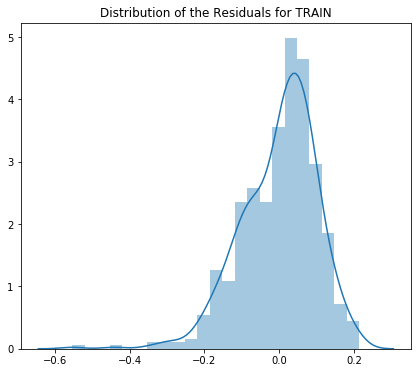

In [39]:
# Residual Analysis
# -----------------

y_train_predicted = lr_mod_8.predict(X_train_sm)
residuals = y_train - y_train_predicted

# Plotting the Residuals
# 
plt.figure(figsize = (7,6))
sns.distplot(residuals)
plt.title("Distribution of the Residuals for TRAIN")
plt.show()

In [40]:
# MAKING PREDICTIONS
# ==================
num_vars = ['temp', 'atemp', 'hum', 'windspeed','casual', 'registered', 'cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,mnth_Oct,mnth_Sept,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thur,weekday_Tue,weekday_Wed,weathersit_Light-Rain-Snow/Thunderstorm,weathersit_Mist/Cloudy
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.933557,0.427086,0.692706,...,0,0,0,0,0,0,0,1,0,1
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.265163,0.767976,0.712034,...,0,0,0,0,0,1,0,0,0,0
299,0,0,0,0.511964,0.496145,0.837699,0.334206,0.072539,0.346376,0.303382,...,1,0,0,1,0,0,0,0,0,1
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.268820,0.559630,0.547400,...,0,0,0,0,0,0,0,0,0,0
152,0,0,0,0.817246,0.741471,0.314298,0.537414,0.223712,0.608143,0.569029,...,0,0,0,1,0,0,0,0,0,0


In [41]:
y_test = df_test.pop('cnt')

In [42]:
X_test = df_test

In [43]:
X_test = X_test[col]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 184 to 189
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   yr             183 non-null    int64  
 1   holiday        183 non-null    int64  
 2   workingday     183 non-null    int64  
 3   temp           183 non-null    float64
 4   atemp          183 non-null    float64
 5   casual         183 non-null    float64
 6   registered     183 non-null    float64
 7   season_Spring  183 non-null    uint8  
 8   mnth_Dec       183 non-null    uint8  
 9   mnth_Feb       183 non-null    uint8  
 10  mnth_Jan       183 non-null    uint8  
 11  mnth_July      183 non-null    uint8  
 12  mnth_June      183 non-null    uint8  
 13  mnth_Nov       183 non-null    uint8  
 14  weekday_Mon    183 non-null    uint8  
dtypes: float64(4), int64(3), uint8(8)
memory usage: 12.9 KB


In [44]:
# Add the constant to X_test
X_test_sm = sm.add_constant(X_test)

In [45]:
# Dropped columns from the above Linear Models
X_test_sm.drop(['temp','atemp','registered','mnth_Nov', 'mnth_Dec', 'mnth_Feb', 'mnth_July'],inplace=True, axis=1)


In [47]:
# ----------------------------
# Making the Predictions
# ----------------------------
y_test_pred = lr_mod_8.predict(X_test_sm)

In [48]:
# Evaluate
# --------

# R-Squared Value
r2 = r2_score(y_true = y_test, y_pred = y_test_pred)
print("R-Squared Value : ", r2)

# Root Mean Squared Error
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_test, y_test_pred, squared=False)
print("Root Mean Squared Error Value : ",rms)

R-Squared Value :  0.7872157505050228
Root Mean Squared Error Value :  0.09926514984216941


In [4]:
# From observing the R-Square value, we can say that - 
# Whatever the model has learned on the Training Set, 
#  it has generalized well on the Test Set.

# Also we observe a low value of Root Mean Squared Error value, 
#  which describes the model as good.